In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
from yellowbrick.regressor import AlphaSelection

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

In [52]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [2]:
# Read in data from pkl
train = pd.read_pickle('final_train_set.pkl')
test = pd.read_pickle('final_test_set.pkl')
data_errors = pd.read_pickle('prices_for_data_errors.pkl')

y_train = np.log(train['price'])
X_train = train.iloc[:,2:]
X_test = test.iloc[:,1:]

In [3]:
def submission_scores(y_pred, missing_values, filename):

    y_pred = pd.Series(y_pred)
    
    y_sub = pd.concat([test.id, y_pred], axis = 1)
    y_sub.columns = ['Id', 'Predicted']
    submission = pd.concat([missing_values, y_sub]).sort_values(by='Id')
    
    submission.to_csv(filename+'.csv', index=False)
    
    return submission

### Lasso regression

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
from sklearn.linear_model import LassoCV

alphas = list(np.logspace(-15, -10, 151, base=2))

lasso = LassoCV(cv=15, alphas=alphas)
lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=[3.0517578125e-05, 3.1230892700096886e-05, 3.1960880213031815e-05, 3.270793037525308e-05, 3.347244200728228e-05, 3.42548232516288e-05, 3.505549179068098e-05, 3.587487506969019e-05, 3.671341052496696e-05, 3.7571545817410796e-05, 3.844973907149883e-05, 3.9348459119860216e-05, 4.026818575356734e...8903539927326339, 0.0009111650307976637, 0.0009324625038187663, 0.0009542577816740684, 0.0009765625],
    copy_X=True, cv=15, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [6]:
result_lasso = np.sqrt(-1*np.mean(cross_val_score(lasso, X_train, np.exp(y_train), cv=10, scoring='neg_mean_squared_error')))

### Random Forest Regression 

In [7]:
#%%time

model = RandomForestRegressor()

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
    'n_estimators' : [100, 200, 500]
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 15, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 11} 



In [12]:
rf.fit(X_train, y_train)
result_rf = np.sqrt(-1*np.mean(cross_val_score(rf, X_train, np.exp(y_train), cv=15, scoring='neg_mean_squared_error')))
print(result_rf)

128.9415768604318


### XGBoost

In [10]:
#%%time

model = xgb.XGBRegressor()

tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [250, 500, 750, 1000, 1500],
    'max_depth' : [2, 3, 4],
    'subsample' : [0.6, 0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 15, return_train_score=False, n_jobs=4,
                              random_state = 20)
gb_search.fit(X_train, y_train)

xbst = gb_search.best_estimator_


print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

Best parameters found by randomised search: {'subsample': 1.0, 'n_estimators': 750, 'max_depth': 3, 'learning_rate': 0.05} 



In [11]:
result_xbst = np.sqrt(-1*np.mean(cross_val_score(xbst, X_train, np.exp(y_train), cv=10, scoring='neg_mean_squared_error')))
result_xbst

132.81586583838205

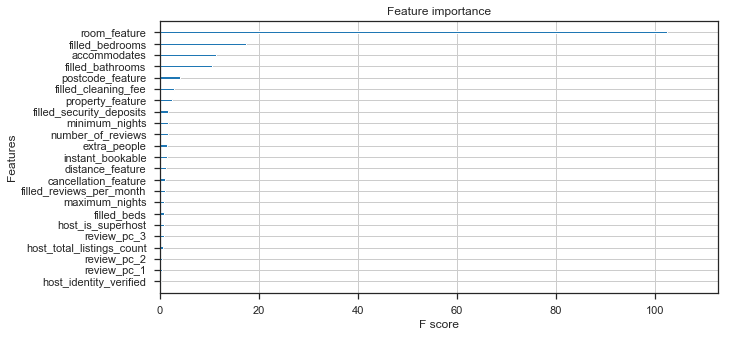

In [53]:
from xgboost import plot_importance

#plt.barh(np.arange(0, len(xbst.feature_importances_)), xbst.feature_importances_)

fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xbst, ax=ax, importance_type='gain', show_values=False)


plt.show()

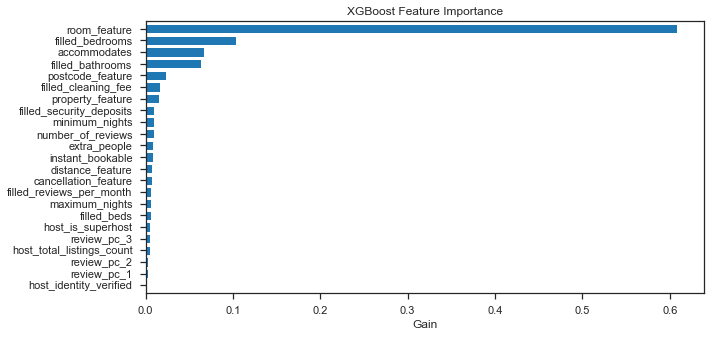

In [64]:
feat_importances = pd.Series(xbst.feature_importances_, index=X_train.columns)

fig, ax = plt.subplots(figsize=(10, 5))
feat_importances.sort_values(ascending=True).plot(kind='barh', ax=ax, width=0.8)
ax.set_title('XGBoost Feature Importance')
ax.set_xlabel('Gain')

plt.savefig(os.path.join('XGB_feature_importance.png'))

plt.show()

room_feature                 0.608253
filled_bedrooms              0.103798
accommodates                 0.067120
filled_bathrooms             0.062932
postcode_feature             0.023910
filled_cleaning_fee          0.016888
property_feature             0.015219
filled_security_deposits     0.010205
minimum_nights               0.009972
number_of_reviews            0.009738
extra_people                 0.008751
instant_bookable             0.008559
distance_feature             0.007179
cancellation_feature         0.006928
filled_reviews_per_month     0.006438
maximum_nights               0.005887
filled_beds                  0.005642
host_is_superhost            0.005160
review_pc_3                  0.004993
host_total_listings_count    0.004539
review_pc_2                  0.003277
review_pc_1                  0.003212
host_identity_verified       0.001400
dtype: float32

### PCA KNN regression

In [ ]:
def pca_reduction(data, features, components=4):
    x = data.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    pd.DataFrame(x, columns = features)
    pca1 = PCA(n_components=components)
    principal_components = pca1.fit_transform(x)
    principal_df = pd.DataFrame(data = principal_components)
    exp_var = pca1.explained_variance_ratio_
    
    return pca1

In [ ]:
pca = pca_reduction(X_train, X_train.columns)
knn_pca = KNeighborsRegressor(n_neighbors = 7)
knn_pca.fit(y=y_train, X=X_train)

In [ ]:
result_knn = np.sqrt(-1*np.mean(cross_val_score(knn_pca, X_train, np.exp(y_train), cv=10, scoring='neg_mean_squared_error')))

### Model stack

In [ ]:
#%%time

models = [lasso, knn_pca, xbst, rf]
model_names = ['Lasso', 'KNN_PCA', 'XGBoost', 'Random Forest']

stack = StackingCVRegressor(models, meta_regressor = LinearRegression(), cv=10)
stack.fit(X_train.values, y_train.ravel())

In [ ]:
#%%time

result_stack = np.sqrt(-1*np.mean(cross_val_score(stack, X_train.values, np.exp(y_train).ravel(), cv=5, scoring='neg_mean_squared_error')))

In [ ]:
y_pred_stack = stack.predict(X_test.values)
y_pred_rf = rf.predict(X_test.values)

In [ ]:
#submission_scores(np.exp(y_pred_rf), data_errors, 'RF_submission_scores')